In [1]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from trading_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe, calc_romad)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [9]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
                 'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [ ]:
def monte_carlo_data(blueprint_data, num_new_points, starting_price=None):
    log_returns = np.log((blueprint_data['Close'].pct_change().dropna() + 1))
    avg_return = log_returns.mean()
    variance = log_returns.var(ddof=0)
    stddev = np.sqrt(variance)
    drift = avg_return - (variance / 2)
        
    if starting_price:
        price = starting_price
    else:
        price = blueprint_data['Close'].values[-1]
    new_data = []
    for _ in range(num_new_points):
        new_data_point = price * np.exp(drift + (stddev * np.random.normal()))
        new_data.append(new_data_point)
        price = new_data_point
    return np.array(new_data)

In [ ]:
for file, data in loaded_files.items():
    data = data.resample('1D').agg({'Open':'first','High':'max','Low':'min','Close':'last'})
    data.dropna(inplace=True) 

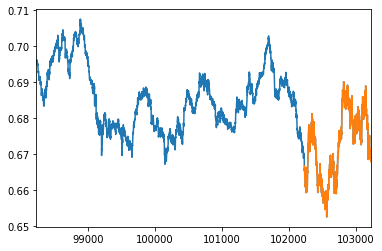

In [4]:
data = loaded_files['AUDUSD_1h_2003-2020.csv']   
new_data = monte_carlo_data(data, num_new_points=1000)

extended_data = pd.DataFrame(pd.Series(np.concatenate([data['Close'].to_numpy(), new_data], axis=0), name='new_data'))

new_series = extended_data.to_numpy().copy()
new_series[:data.shape[0]] = np.nan
extended_data['new_series'] = new_series
extended_data['new_data'][-5000:].plot()
extended_data['new_series'][-5000:].plot()
plt.show()

In [48]:
starting_price = 1
all_data = []
for file, data in loaded_files.items():
    new_data = monte_carlo_data(data, num_new_points=5000, starting_price=starting_price)
    starting_price = new_data[-1]
    all_data.append(new_data)
all_data_concat = np.concatenate(all_data, axis=0)

# data = loaded_files['AUDUSD_1h_2003-2020.csv']
# new_data = monte_carlo_data(data, num_new_points=100000, starting_price=None)

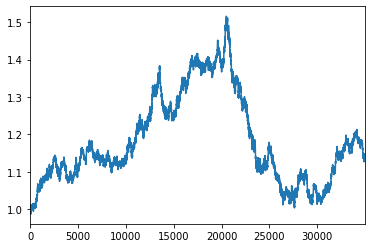

In [49]:
pd.Series(all_data_concat).plot()

In [50]:
pd.DataFrame(pd.Series(all_data_concat, name='Close')).to_csv('monte_carlo_audusd.csv', index=False)

In [32]:
pd.read_csv('monte_carlo_audusd.csv')

,Close
0,0.999233
1,1.001016
2,1.000751
3,1.000888
4,0.999136
...,...
3499995,0.035332
3499996,0.035313
3499997,0.035281
3499998,0.035308


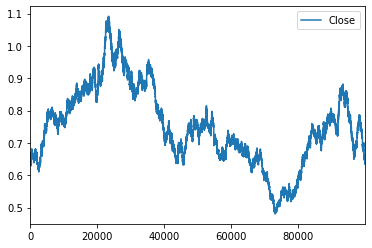

In [8]:
raw_data = pd.read_csv('monte_carlo_audusd.csv')
raw_data.plot()